### Problem 1

In [1]:
import numpy as np
import qflib as qf
import matplotlib.pyplot as plt

qf.version()

'0.10.0-debug'

In [2]:
qf.mktClear()

times = [1.0, 2.0]
rates = [0.04, 0.04]
qf.ycCreate("flat4", times, rates, 0)

vols = [0.40, 0.60]
qf.volCreate("nonflatVol", times, vols, 0)

spot = 100.0
strike = 100.0
time_to_exp = 1.0
div_yield = 0.0
ycname = "flat4"
volname = "nonflatVol"

pde_cn = {"THETA": 0.5, "NSPOTNODES": 800, "NTIMESTEPS": 800, "NSTDDEVS": 6.0}
pde_impl = {"THETA": 1.0, "NSPOTNODES": 800, "NTIMESTEPS": 800, "NSTDDEVS": 6.0}

result_cn_handle = qf.euroBSPDE(-1, strike, time_to_exp, spot, ycname, div_yield, volname, pde_cn, False)
result_impl_handle = qf.euroBSPDE(-1, strike, time_to_exp, spot, ycname, div_yield, volname, pde_impl, False)

scalar_vol = qf.spotVol(volname, time_to_exp)

result_cn_scalar = qf.euroBSPDE(-1, strike, time_to_exp, spot, ycname, div_yield, scalar_vol, pde_cn, False)
result_impl_scalar = qf.euroBSPDE(-1, strike, time_to_exp, spot, ycname, div_yield, scalar_vol, pde_impl, False)

# Output results
print("ATM 1Y European Put Option via PDE (800x800 Grid):\n")
print(f"Crank-Nicholson (θ=0.5), vol handle:   {result_cn_handle['Price']:.6f}")
print(f"Crank-Nicholson (θ=0.5), scalar vol:   {result_cn_scalar['Price']:.6f}")
print(f"Implicit (θ=1.0), vol handle:          {result_impl_handle['Price']:.6f}")
print(f"Implicit (θ=1.0), scalar vol:          {result_impl_scalar['Price']:.6f}")

ATM 1Y European Put Option via PDE (800x800 Grid):

Crank-Nicholson (θ=0.5), vol handle:   13.656798
Crank-Nicholson (θ=0.5), scalar vol:   13.656798
Implicit (θ=1.0), vol handle:          13.654532
Implicit (θ=1.0), scalar vol:          13.654532


### Problem 2

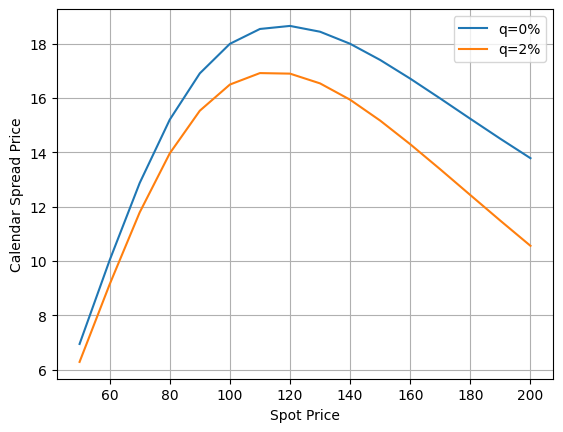

In [3]:
qf.mktClear()

times = [1.0, 2.0]
rates = [0.04, 0.04]
vols = [0.40, 0.60]
qf.ycCreate("flat4", times, rates, 0)
qf.volCreate("nonflatVol", times, vols, 0)

strike = 100.0
T1 = 1.0
T2 = 2.0
ycname = "flat4"
volname = "nonflatVol"
n_nodes = 800
n_timesteps = 800
spots = np.arange(50, 201, 10)

pdeparams = {
    "THETA": 0.5,
    "NSPOTNODES": n_nodes,
    "NTIMESTEPS": n_timesteps,
    "NSTDDEVS": 6.0
}

def calendar_spread(spot_vals, div_yield):
    T1_prices = [qf.euroBSPDE(1, strike, T1, s, ycname, div_yield, volname, pdeparams)["Price"] for s in spot_vals]
    T2_prices = [qf.euroBSPDE(1, strike, T2, s, ycname, div_yield, volname, pdeparams)["Price"] for s in spot_vals]
    return np.array(T2_prices) - np.array(T1_prices)

spread_q0 = calendar_spread(spots, 0.00)
spread_q2 = calendar_spread(spots, 0.02)

plt.plot(spots, spread_q0, label='q=0%')
plt.plot(spots, spread_q2, label='q=2%')
plt.xlabel("Spot Price")
plt.ylabel("Calendar Spread Price")
plt.legend()
plt.grid(True)
plt.show()

### Problem 3

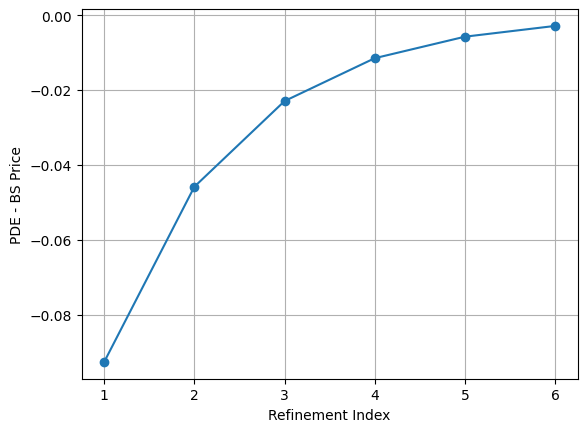

In [4]:
qf.mktClear()
qf.ycCreate("flat4", [1.0, 2.0], [0.04, 0.04], 0)
qf.volCreate("nonflatVol", [1.0, 2.0], [0.4, 0.6], 0)

strike = 100.0
spot = 100.0
timetoexp = 1.0
divyield = 0.0
discountcrv = "flat4"
volname = "nonflatVol"
payofftype = -1

bs_price = qf.digiBS(payofftype, spot, strike, timetoexp, 0.04, divyield, 0.4)[0]

levels = [25, 50, 100, 200, 400, 800]
errors = []

for n in levels:
    pdeparams = {
        "THETA": 0.5,
        "NSPOTNODES": n,
        "NTIMESTEPS": n,
        "NSTDDEVS": 6.0
    }
    price = qf.digiBSPDE(payofftype, strike, timetoexp, spot, discountcrv, divyield, volname, pdeparams, False)['Price']
    errors.append(price - bs_price)

plt.plot(range(1, len(levels)+1), errors, marker='o')
plt.xlabel("Refinement Index")
plt.ylabel("PDE - BS Price")
plt.grid(True)
plt.show()

The error on the plot follows approximately linear scaling. As the refinement index increases, the error reduces by about half at each step, particularly between early refinements. This pattern indicates that the convergence rate of the PDE solution with respect to grid refinement is first-order rather than second-order, consistent with linear error scaling rather than quadratic.